In [31]:
import numpy as np
import pandas as pd
import math
from scipy import signal
from scipy import stats
import scipy
import matplotlib.pyplot as plt 
import math

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

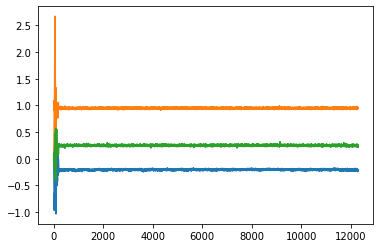

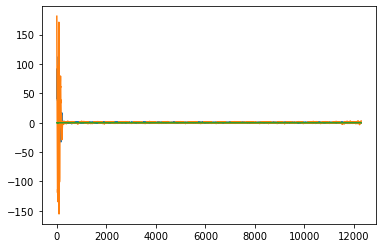

In [32]:
df = pd.read_csv('dataset/dataset_1.txt', sep=',', header=None)
df_sitting = df[df[24] == 1].values
plt.plot(df_sitting[:, 0:3])
plt.show()
plt.plot(df_sitting[:,4:7])
plt.show()

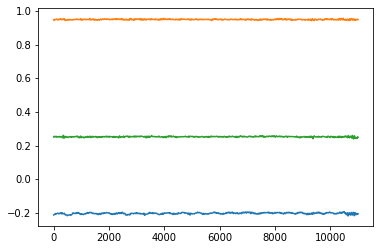

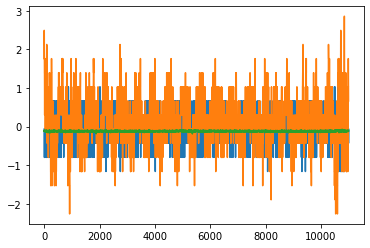

In [33]:
 df = pd.read_csv('dataset/dataset_1.txt', sep=',', header=None)
b, a = signal.butter(4, 0.04, 'low', analog=False)
df_sitting = df[df[24] == 1].values
for i in range(3):
    df_sitting[:,i] = signal.lfilter(b, a, df_sitting[:, i])
plt.plot(df_sitting[1000:12000, 0:3])
plt.show()
plt.plot(df_sitting[1000:12000, 4:7])
plt.show()

In [34]:
    training = np.empty(shape=(0, 10))
    testing = np.empty(shape=(0, 10))
    for i in range(19):
        df = pd.read_csv('dataset/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
        print('deal with dataset ' + str(i + 1))
        for c in range(1, 14):
            activity_data = df[df[24] == c].values
            b, a = signal.butter(4, 0.04, 'low', analog=False)
            for j in range(24):
                activity_data[:, j] = signal.lfilter(b, a, activity_data[:, j])
            
            datat_len = len(activity_data)
            training_len = math.floor(datat_len * 0.8)
            training_data = activity_data[:training_len, :]
            testing_data = activity_data[training_len:, :]

            
            training_sample_number = training_len // 1000 + 1
            testing_sample_number = (datat_len - training_len) // 1000 + 1

            for s in range(training_sample_number):
                if s < training_sample_number - 1:
                    sample_data = training_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = training_data[1000*s:, :]
               
                feature_sample = []
                for i in range(3):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                    feature_sample.append(np.median(sample_data[:, i]))
                    feature_sample.append(np.std(sample_data[:, i]))
                    feature_sample.append(scipy.stats.mode(sample_data[:, i]))
                    
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                training = np.concatenate((training, feature_sample), axis=0)
                
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                testing = np.concatenate((testing, feature_sample), axis=0)
            
            for s in range(testing_sample_number):
                if s < training_sample_number - 1:
                    sample_data = testing_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = testing_data[1000*s:, :]

    df_training = pd.DataFrame(training)
    df_testing = pd.DataFrame(testing)
    df_training.to_csv('training_data.csv', index=None, header=None)
    df_testing.to_csv('testing_data.csv', index=None, header=None)
    print()
    
    

deal with dataset 1


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [35]:
def model_training_and_evaluation_example():
    
    df_training = pd.read_csv('training_data.csv', header=None)
    df_testing = pd.read_csv('testing_data.csv', header=None)

    y_train = df_training[9].values
    y_train = y_train - 1
    df_training = df_training.drop([9], axis=1)
    X_train = df_training.values

    y_test = df_testing[9].values
    y_test = y_test - 1
    df_testing = df_testing.drop([9], axis=1)
    X_test = df_testing.values
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    

   
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2, 1e-3, 1e-4],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]},
                    {'kernel': ['linear'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}]
    acc_scorer = make_scorer(accuracy_score)
    grid_obj  = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=acc_scorer)
    grid_obj  = grid_obj .fit(X_train, y_train)
    clf = grid_obj.best_estimator_
    print('best clf:', clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))



if __name__ == '__main__':
    
        model_training_and_evaluation_example()

Accuracy:  0.7504798464491362
[[ 43   3   0   0   0   1   0   0   0   0   7   3   0]
 [  3  54   0   0   0   0   0   0   0   0   0   0   0]
 [  0   3  48   1   2   0   1   0   0   0   1   1   0]
 [  2   0   2  84   4   5   1   1   0   0   0   0   0]
 [  0   0   1   8  36   7   1   3   0   0   1   0   0]
 [  1   1   2  14  26  32   4   1   1   0   1   2   0]
 [  1   0   6   4   2   6 191   4   5   0   0   0   0]
 [  0   0   1   0   0   2  14  21   1   0   0   0   0]
 [  0   0   0   1   0   1   9   2  24   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0  96   0   0   0]
 [  0   0   1   3   2   7   2   0   0   0  58  27   0]
 [  0   0   1   1   0   0   0   0   0   0  39  59   0]
 [  0   0   0   1   0   0   1   0   0   0   0   0  36]]


KeyboardInterrupt: 